In [1]:
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# from imblearn.over_sampling import SMOTE
# import matplotlib.pyplot as plt
# import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    RocCurveDisplay,
    f1_score,
    classification_report,
    precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_recall_curve
    )
from sklearn.svm import SVC
from sklearn.model_selection import (
    RandomizedSearchCV,
    GridSearchCV,
    cross_val_score,
    train_test_split
    )
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import(
    OneHotEncoder,
    StandardScaler,
    PolynomialFeatures,
    MinMaxScaler
    )

from sklearn.feature_selection import (
    SequentialFeatureSelector,
    f_classif,
    SelectKBest,
    SelectFromModel,
    VarianceThreshold)


from imblearn.pipeline import Pipeline as imb_pipe
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from scipy.signal import savgol_filter

In [2]:
data = pd.read_csv("loan_data.csv").drop("LoanID",axis=1)
target=data.pop("Default")

In [3]:
categorical_features = ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage',
                        'HasDependents', 'LoanPurpose', 'HasCoSigner']

quant_features = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
                  'NumCreditLines', 'LoanTerm', 'InterestRate', 'DTIRatio']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data,target, test_size=0.2, random_state=408,stratify=target)
default_preprocessor = ColumnTransformer([("one_hot",OneHotEncoder(drop="first"),categorical_features),
                                  ("standardize",StandardScaler(),quant_features)
                                  ])

predictions={}

## Utility Functions

In [5]:
def show_confusion_matrix(clf,X,y,preds=None):
    y_pred=preds if preds is not None else clf.predict(X)
    cm=confusion_matrix(y,y_pred)
    ConfusionMatrixDisplay(cm,display_labels=["No Default","Default"]).plot()
    plt.show()

In [6]:

def name_mapper(name):
    result=re.sub('^(one_hot__|standardize__)',"",name)
    return re.sub(" (one_hot__|standardize__)"," * ",result)


In [8]:
def plot_features(feature_names,values,value_name:str="Importance",max_features=30,**plot_kwargs):
    formatted_feature_names=[name_mapper(name) for name in feature_names]
    feature_df=pd.DataFrame({"Feature":formatted_feature_names,value_name:values}).sort_values(value_name,ascending=False)
    # Plot feature importances
    return sns.barplot(x=value_name,y="Feature",data=feature_df.iloc[:max_features],hue=value_name,legend=False,**plot_kwargs)


## Random Forest

In [9]:
initial_tree=imb_pipe(steps=[
    ("preprocessor",default_preprocessor),
    ("undersampler",RandomUnderSampler(random_state=42,sampling_strategy=0.4)),
    ("classifier",RandomForestClassifier(random_state=42,
                                         max_depth=80,
                                         min_samples_leaf=1,
                                         min_samples_split=2,
                                         n_estimators=200))
    ])

In [10]:


initial_tree.fit(X_train,y_train)
rf_y_pred =initial_tree.predict(X_test)

predictions["Random Forest"]=rf_y_pred
report = classification_report(y_test, rf_y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.92     45139
           1       0.37      0.28      0.32      5931

    accuracy                           0.86     51070
   macro avg       0.64      0.61      0.62     51070
weighted avg       0.85      0.86      0.85     51070



### Logistic Regression

In [11]:
log_reg_pipe=imb_pipe(steps=[("preprocessor", default_preprocessor),
                    ("resampler",RandomUnderSampler(random_state=28)),
                    
                    ("classifier", LogisticRegression(penalty=None))
    ])

log_reg_pipe.fit(X_train,y_train)
cv_scores = cross_val_score(log_reg_pipe, X_train,y_train, cv=5, scoring='precision') 
print("Cross-validation precision scores:", cv_scores)
print("Mean precision score:", cv_scores.mean())

print("Test Set Classification Report:")
log_reg_y_pred=log_reg_pipe.predict(X_test)
predictions["Logistic Regression"]=log_reg_y_pred
print(classification_report(y_test,log_reg_y_pred))


Cross-validation precision scores: [0.21452602 0.2188273  0.21862673 0.21815881 0.21583113]
Mean precision score: 0.2171939999794132
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.67      0.79     45139
           1       0.22      0.70      0.33      5931

    accuracy                           0.68     51070
   macro avg       0.58      0.68      0.56     51070
weighted avg       0.86      0.68      0.73     51070



#### Visualizing Predicting Probs

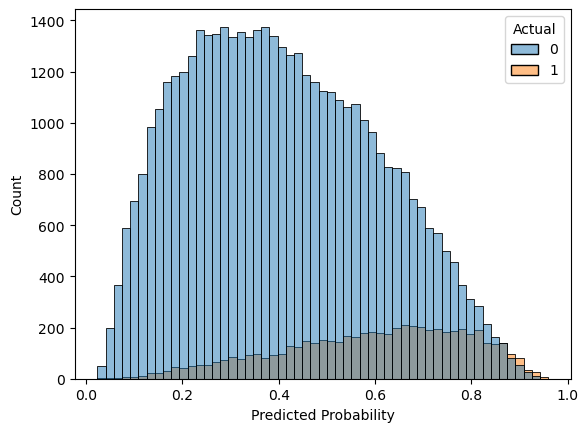

In [12]:
y_proba=[x[1] for x in log_reg_pipe.predict_proba(X_test)]
pred_data=pd.DataFrame({"Predicted Probability":y_proba,"Actual":y_test})
sns.histplot(data=pred_data,x="Predicted Probability",hue="Actual")
plt.show()

#### Choosing Decision Threshold

In [14]:
precision,recall, threshold=precision_recall_curve(y_test,y_proba)
accuracies=[]
tot=len(y_test)
accuracies=[np.sum((y_proba>t)==y_test)/tot for t in threshold]
f1=((precision * recall)/(precision+recall))[:-1]
df=pd.DataFrame({"precision":precision[:-1],
                 "recall":recall[:-1],
                 "accuracy":accuracies,
                 "threshold":threshold,
                 "f1":f1}).melt(id_vars="threshold",var_name="metric")

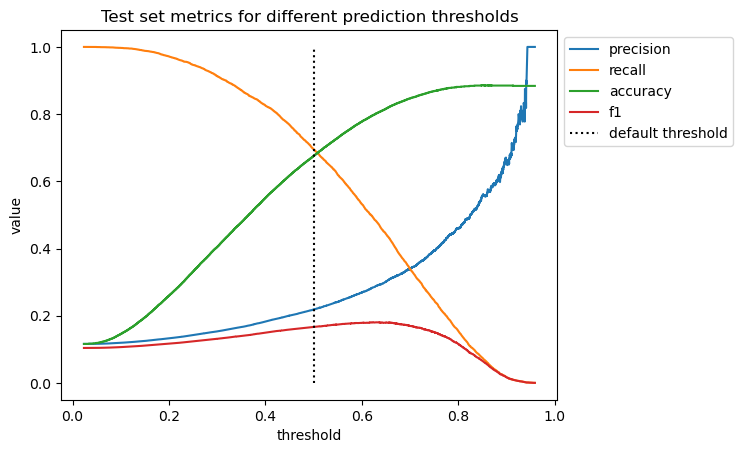

In [ ]:
ax=sns.lineplot(data=df,x='threshold',hue='metric',y='value')
plt.vlines(0.5,0,1,colors='black',linestyles='dotted',label='default threshold')
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.title("Test set metrics for different prediction thresholds")
plt.show()

### Polynomial features

In [ ]:

poly = PolynomialFeatures(degree=2,include_bias=False,interaction_only=True)
results=[]
lasso_log_reg = LogisticRegression(penalty='l1', solver='saga', max_iter=5000, random_state=42)

# Define SelectFromModel with Lasso Logistic Regression
lasso_feature_selection = SelectFromModel(estimator=lasso_log_reg,max_features=40)
poly_pipe= imb_pipe(steps=[
    ("preprocessor", default_preprocessor),
    ("resampler",RandomUnderSampler(sampling_strategy=0.4,random_state=741)),
    ("polynomial features",poly),
    ("variance threshold",VarianceThreshold()),
    ("lasso feature selection",lasso_feature_selection),
    ("classifier", LogisticRegression(penalty=None,max_iter=5000,solver='saga'))
    ]
    )
poly_pipe.fit(X_train,y_train)
cross_val_score(poly_pipe,X_train,y_train,scoring='precision')

array([0.34956685, 0.3586676 , 0.34242709, 0.3504496 , 0.35719348])

In [ ]:
poly_preds=poly_pipe.predict(X_test)
predictions["Polynomial Logistic Regression"]=poly_preds
print(classification_report(y_test,poly_preds))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92     45139
           1       0.36      0.32      0.34      5931

    accuracy                           0.85     51070
   macro avg       0.63      0.62      0.63     51070
weighted avg       0.85      0.85      0.85     51070



### Support Vector Classifier

In [ ]:

from imblearn.pipeline import make_pipeline as make_pipeline_imblearn


svm = SVC(C=0.5, kernel='rbf', class_weight='balanced')  # Adjust class weights for sensitivity

# Create a pipeline that includes preprocessing, RandomUnderSampler, and the SVM classifier
svm_pipe = make_pipeline_imblearn(
    default_preprocessor,
    RandomUnderSampler(random_state=42),  # RandomUnderSampler for handling class imbalance
    svm
)

# Train the model using the pipeline
svm_pipe.fit(X_train, y_train)

# Predict using the test set
y_pred = svm_pipe.predict(X_test)

# Output the classification report to evaluate the model
print(classification_report(y_test, y_pred))

# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix with Random Undersampling')
plt.show()



In [ ]:
predictions["SVC"]=(y_pred

### Comparing Models

In [ ]:
df_list=[]
for name,y_pred in predictions.items():
    report=classification_report(y_test,y_pred,output_dict=True)
    abridged_report=report['1']
    abridged_report.pop("support")
    abridged_report['accuracy']=report['accuracy']
    abridged_report['model']=name
    df_list.append(abridged_report)
    

model_result_df=pd.DataFrame(df_list)

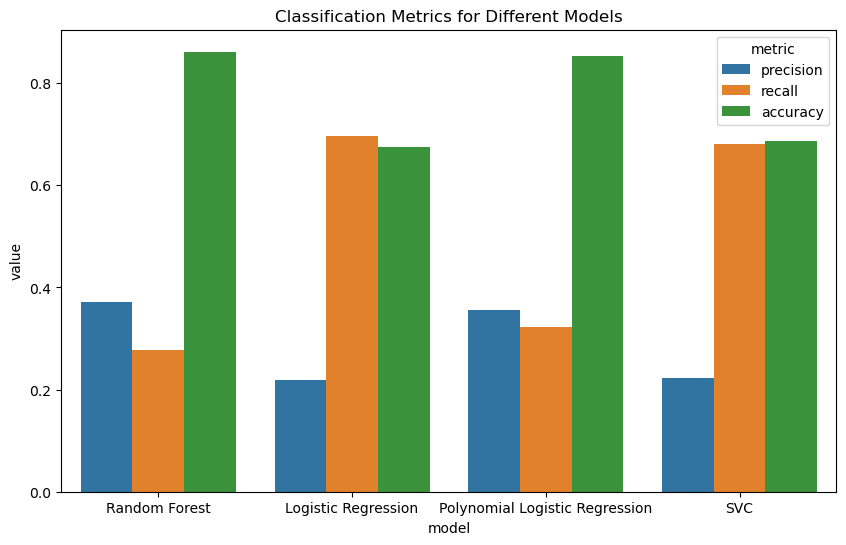

In [ ]:
include_vars=[
    'precision',
    'recall',
    #'f1-score',
    'accuracy'
]
plt.figure(figsize=(10, 6)) 
melted=model_result_df.melt(id_vars='model',value_vars=include_vars,var_name='metric')
sns.barplot(data=melted,x='model',y='value',hue='metric')
plt.title("Classification Metrics for Different Models")
plt.show()


/var/folders/04/4rlrthlj0_vfxl8m3n0sdg5h0000gn/T/ipykernel_8203/1654446848.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


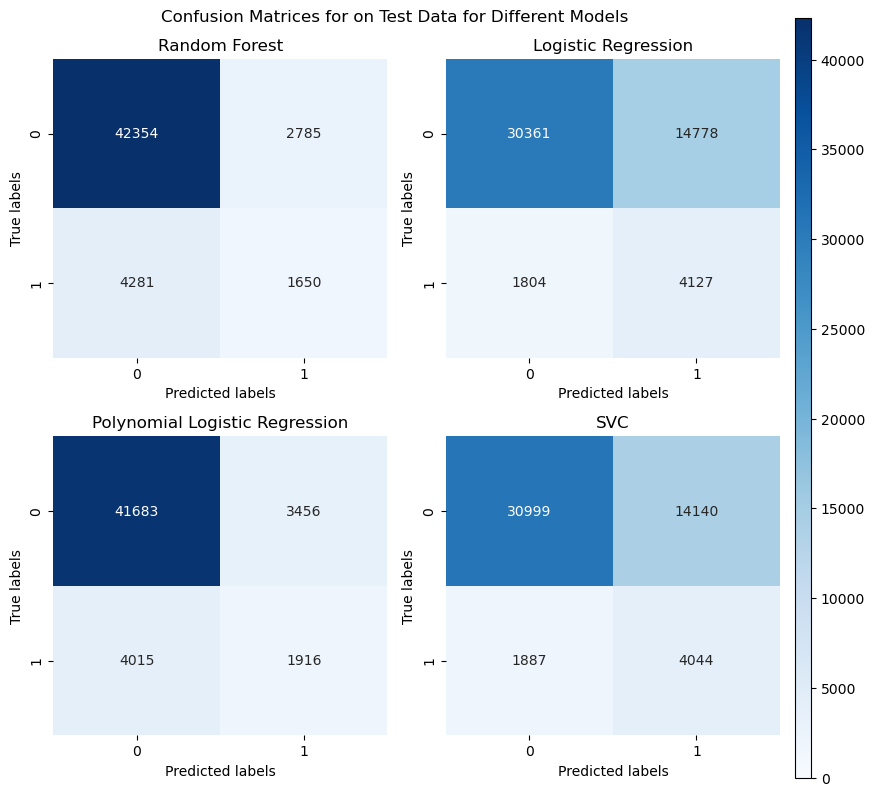

In [ ]:
max_cm_value = max([confusion_matrix(y_test, y_pred).max() for y_pred in predictions.values()])

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Iterate over each model's predictions and corresponding axis
for ax, (model_name, y_pred) in zip(axes.flatten(), predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, norm=plt.Normalize(vmin=0, vmax=max_cm_value),cbar=False)
    ax.set_title(f'{model_name}')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

# Add a colorbar to the last axis
cax = fig.add_axes([1, 0.02, 0.02, 0.95])
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=max_cm_value))
sm._A = []  # fake up the array of the scalar mappable
cbar = fig.colorbar(sm, cax=cax)
fig.suptitle("Confusion Matrices for on Test Data for Different Models")

plt.tight_layout()
plt.show()

# # Plot confusion matrices
# fig, axes = plt.subplots(2,2, figsize=(8, 8))
# for ax, (model_name, y_pred) in zip(axes.flatten(),predictions.items()):
#     cm=confusion_matrix(y_test,y_pred)
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
#     ax.set_title(f'Confusion Matrix - {model_name}')
#     ax.set_xlabel('Predicted labels')
#     ax.set_ylabel('True labels')
# plt.tight_layout()
# plt.show()

### Feature Importance

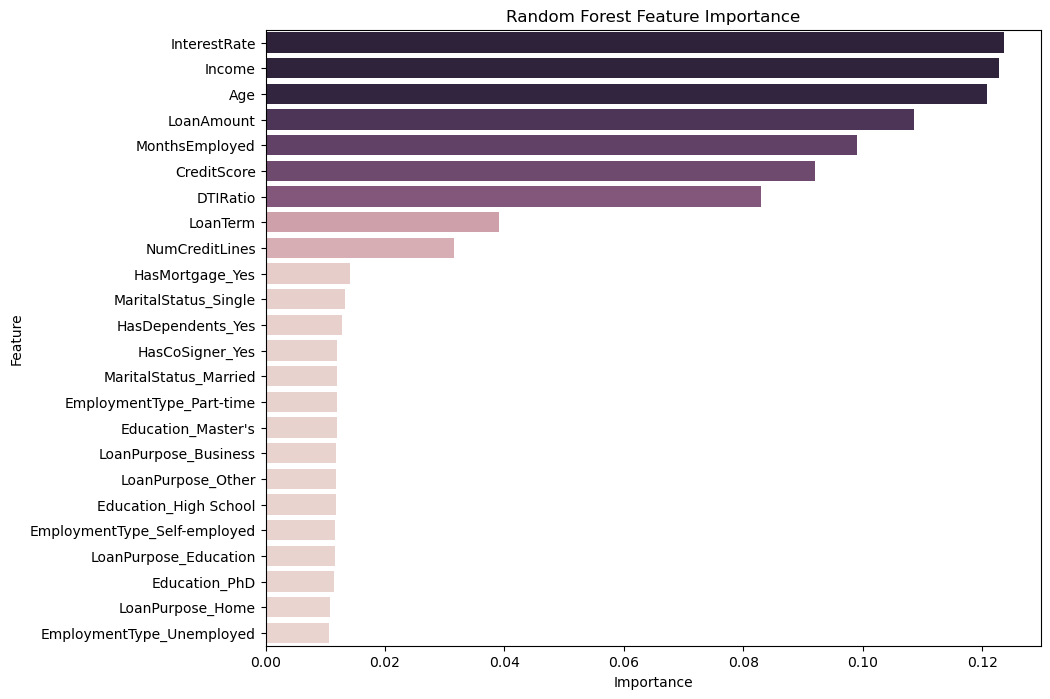

In [133]:

# Get feature importancs
rf_importances = initial_tree[-1].feature_importances_
rf_feature_names=initial_tree[:-1].get_feature_names_out()
formatted_feature_names=np.array([name_mapper(feature) for feature in rf_feature_names])
feature_df=pd.DataFrame({"Feature":formatted_feature_names,"Importance":rf_importances}).sort_values("Importance",ascending=False)
# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x="Importance",y="Feature",data=feature_df.iloc[:50],hue="Importance",legend=False)

plt.title('Random Forest Feature Importance')
plt.show()

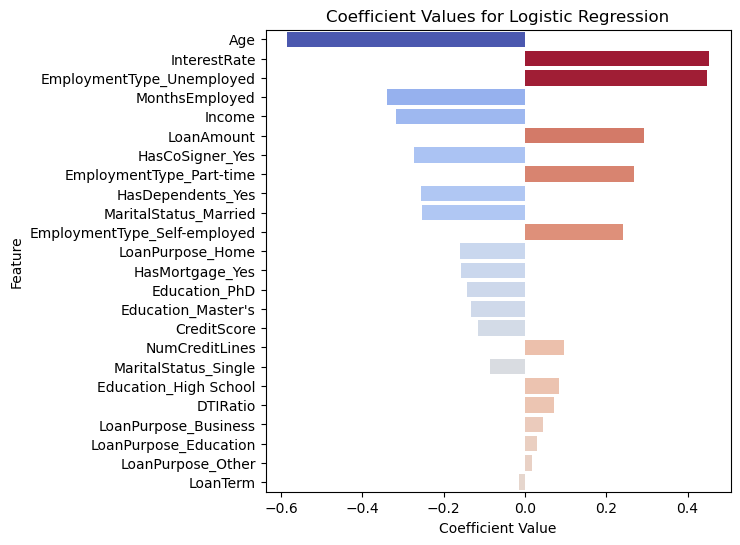

In [142]:
log_reg_coefs=log_reg_pipe[-1].coef_[0,:]
log_reg_df=pd.DataFrame({"Feature":log_reg_pipe[:-1].get_feature_names_out(),"Coefficient Value":log_reg_coefs})
log_reg_df["Feature"]=log_reg_df["Feature"].apply(name_mapper)
log_reg_df['abs']=log_reg_df["Coefficient Value"].apply(np.abs)
log_reg_df=log_reg_df.sort_values("abs",ascending=False)
plt.figure(figsize=(6,6))
sns.barplot(y="Feature",x="Coefficient Value",data=df,hue="Coefficient Value",palette='coolwarm',legend=False)
plt.title("Coefficient Values for Logistic Regression")
plt.show()


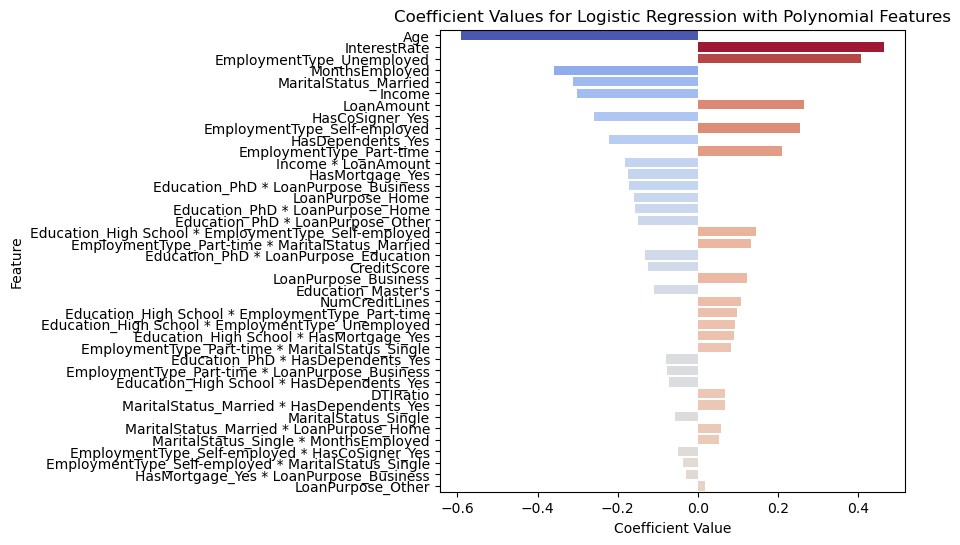

In [153]:
poly_coefs=poly_pipe[-1].coef_[0,:]
poly_feature_df=pd.DataFrame({"Feature":poly_pipe[:-1].get_feature_names_out(),"Coefficient Value":poly_coefs})
poly_feature_df["Feature"]=poly_feature_df["Feature"].apply(name_mapper)
poly_feature_df['abs']=poly_feature_df["Coefficient Value"].apply(np.abs)
poly_feature_df=poly_feature_df.sort_values("abs",ascending=False)
plt.figure(figsize=(6,6))
sns.barplot(y="Feature",x="Coefficient Value",data=poly_feature_df,hue="Coefficient Value",palette='coolwarm',legend=False)
plt.title("Coefficient Values for Logistic Regression with Polynomial Features")
plt.show()


In [152]:
poly_feature_df.drop('abs',axis=1).style.background_gradient(axis=0,gmap=poly_feature_df['Coefficient Value'],cmap='coolwarm')

,Feature,Coefficient Value
12,Age,-0.591015
18,InterestRate,0.463249
3,EmploymentType_Unemployed,0.406714
16,MonthsEmployed,-0.358054
4,MaritalStatus_Married,-0.311009
13,Income,-0.300959
14,LoanAmount,0.265123
11,HasCoSigner_Yes,-0.258130
2,EmploymentType_Self-employed,0.255474
7,HasDependents_Yes,-0.222334


In [241]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(svm_pipe, X_test, y_test)

In [ ]:
feature_names = [name_mapper(name) for name in svm_pipe[:-1].get_feature_names_out()]
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")